In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import warnings
import seaborn as sns

import sys
sys.path.append('D:\Рабочий стол\DS\Крученные рельсы\projects\9684_dev\my_rail_analysis')

plt.style.use('dark_background')

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 12
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 12
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 16
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

warnings.filterwarnings('ignore')

In [17]:
file_path = './data_store/dzr_data_90HAF_with_wbf_stan_50_features.csv'
df = pd.read_csv(file_path, sep=',')
df.head(5)

,tbk_TBK_1_h_ni_0_3_max,tbk_TBK_1_area_ni_0_3_std,tbk_TBK_1_h_ni_0_0.29_q1,tbk_TBK_1_h_ni_0_0.29_q_deviation_aggregate,tbk_TBK_1_area_ni_0.29_1_tg,tbk_TBK_1_area_ni_0.29_1_q_deviation_aggregate,tbk_TBK_1_area_ni_1_5.5_std,tbk_TBK_1_area_ni_1_5.5_tg,tbk_TBK_1_area_ni_5.5_6.6_tg,tbk_TBK_1_area_ni_6.6_9.6_std,...,p_sec1_dwn,p_sec2_dwn,Т_центр_дзр_мин,Т_центр_дзр_сред,to_c1,to_c2,tpz_c2,tpz_c3,tpz_c4,class_num
0,181.13,216.417034,180.965,0.0375,-27.966119,1.78500,8.660434,-2.782877,-20.035443,9.872071,...,33.934959,34.395378,300.0,872.0,821.0,839.0,575.0,568.0,631.0,0
1,181.05,74.366446,180.970,0.0050,-33.352635,1.68500,5.411877,0.814464,-21.653092,10.658445,...,33.783352,33.866425,301.0,792.0,839.0,832.0,566.0,574.0,614.0,0
2,181.01,72.755486,180.315,0.3475,-90.567765,14.13500,7.108826,2.016696,4.361365,6.529499,...,33.846252,34.338745,300.0,777.0,839.0,834.0,568.0,575.0,615.0,0
3,180.92,72.555581,180.820,0.0050,-30.127775,1.81375,10.781713,1.957567,9.909465,3.063746,...,32.901402,34.492546,300.0,778.0,835.0,840.0,572.0,564.0,595.0,0
4,181.74,197.764606,181.495,0.0550,-85.016963,12.59500,4.877770,0.966452,-25.087191,3.172810,...,34.180779,34.321232,300.0,878.0,822.0,839.0,574.0,576.0,620.0,0


### Несбалансированность классов

In [18]:
# 0 - no_defects
# 1 - more_3_defects
df.groupby('class_num').size().to_frame()

,0
class_num,
0,2126
1,92


### Разделим данные на обучающий и тестовый наборы

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(['class_num'], axis=1)
Y = df['class_num']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve, auc

# Определение пайплайна

pipe_LR = Pipeline([
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression(penalty='l2'))
])

# Подбор лучшей модели с помощью GridSearchCV

# Определение функции для вычисления PR AUC
def pr_auc_score(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    return pr_auc

# Создание объекта для применения метрики PR AUC в GridSearchCV
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

param_grid = {
    'LR__penalty': ['l1', 'l2', 'none'],  # тип регуляризации
    'LR__C': [0.001, 0.01, 0.1, 1, 10, 100],  # обратный коэффициент регуляризации
    'LR__solver': ['liblinear', 'saga'],  # алгоритм оптимизации
    'LR__max_iter': [100, 200, 300, 500, 1000],  # максимальное число итераций
}

grid_search = GridSearchCV(pipe_LR,
                           param_grid, 
                           cv = 5, 
                           scoring=pr_auc_scorer)

# Подгонка модели на обучающих данных
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'LR__C': 10, 'LR__max_iter': 100, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}
Лучшая оценка: 0.9469839331936332


In [22]:
# Назначаем лучшую модель
best_pipe_LR = grid_search.best_estimator_

### Логистическая регрессия - Визуализация

In [48]:
def plot_pr_curve(model, X, Y, title='Precision-Recall Curve'):
    """
    Строит PR-кривую для модели и расчитывает площадь под ней.

    Параметры:
    - model: обученная модель для оценки.
    - X: массив признаков выборки.
    - Y: массив целевых значений выборки.
    """
    if hasattr(model, 'predict_proba'):
        # Если доступен метод predict_proba, используем его для получения вероятностей
        y_probas = model.predict_proba(X)[:, 1]
    else:
        # Иначе получаем отступы и применяем сигмоидную функцию для получения вероятностей
        M = model.decision_function(X)
        y_probas = 1 / (1 + np.exp(-M))

    # Получение данных PR-кривой
    precision, recall, _ = precision_recall_curve(Y, y_probas)

    # Построение PR-кривой с настройками внешнего вида
    plt.figure(figsize=(10, 8))  # Размер графика
    plt.plot(recall, precision, color='blue', lw=2, label=f"PR curve: {auc(recall, precision):.3f}")  # Цвет, ширина линии и название кривой
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') # Добавление диагональной пунктирной линии
    plt.xlim([0.0, 1.0])  # Пределы оси x
    plt.ylim([0.0, 1.05])  # Пределы оси y
    plt.xlabel('Recall')  # Подпись оси x
    plt.ylabel('Precision')  # Подпись оси y
    plt.title(title)  # Название графика
    plt.grid(True, alpha=0.1, linestyle="--")  # Включение сетки
    plt.legend(loc="lower left")  # Расположение легенды

    # Закраска площади под PR-кривой
    plt.fill_between(recall, precision, color='purple', alpha=0.3)

    # Отображение графика
    plt.show()

In [52]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X, Y, title='Receiver Operating Characteristic (ROC) Curve'):
    """
    Строит ROC-кривую для модели и расчитывает площадь под ней.

    Параметры:
    - model: обученная модель для оценки.
    - X: массив признаков выборки.
    - Y: массив целевых значений выборки.
    """

    if hasattr(model, 'predict_proba'):
        # Если доступен метод predict_proba, используем его для получения вероятностей
        y_probas = model.predict_proba(X)[:, 1]
    else:
        # Иначе получаем отступы и применяем сигмоидную функцию для получения вероятностей
        M = model.decision_function(X)
        y_probas = 1 / (1 + np.exp(-M))

    # Получение данных ROC-кривой
    fpr, tpr, thresholds = roc_curve(Y, y_probas)

    # Построение ROC-кривой с настройками внешнего вида
    plt.figure(figsize=(10, 8))  # Размер графика
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve: {auc(fpr, tpr):.3f}")  # Цвет, ширина линии и название кривой
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
    plt.xlim([0.0, 1.0])  # Пределы оси x
    plt.ylim([0.0, 1.05])  # Пределы оси y
    plt.xlabel('False Positive Rate')  # Подпись оси x
    plt.ylabel('True Positive Rate')  # Подпись оси y
    plt.title(title)  # Название графика
    plt.grid(True, alpha=0.1, linestyle="--")  # Включение сетки
    plt.legend(loc="lower right")  # Расположение легенды

    # Закраска площади под ROC-кривой
    plt.fill_between(fpr, tpr, color='purple', alpha=0.3)

    # Отображение графика
    plt.show()

In [65]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(model, X, y, n_bins=10, title='Calibration Curve'):
    """
    Строит калибровочную кривую для каждого класса модели.

    Параметры:
    - model: обученная модель для оценки.
    - X: массив признаков выборки.
    - y: массив целевых значений выборки.
    - n_bins: количество бинов для разбиения.
    - title: заголовок графика.
    """
    # Проверяем, доступен ли метод predict_proba
    if hasattr(model, 'predict_proba'):
        # Получаем вероятности для каждого класса
        prob_pos = model.predict_proba(X)
    else:
        # Получаем отступы от гиперплоскости и применяем сигмоидную функцию для получения вероятностей
        M = model.decision_function(X)
        prob_pos = 1 / (1 + np.exp(-M))

    # Получаем уникальные классы
    classes = np.unique(y)

    # Инициализируем график
    plt.figure(figsize=(10, 8))

    # Итерируемся по каждому классу
    for class_index, class_label in enumerate(classes):
        # Получаем бинарные метки для текущего класса
        y_binary = (y == class_label).astype(int)
        # Получаем калибровочную кривую для текущего класса
        fraction_of_positives, mean_predicted_value = calibration_curve(y_binary, prob_pos[:, class_index], n_bins=n_bins)
        # Построение калибровочной кривой для текущего класса
        plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'Class {class_label}')

    # Добавляем диагональную пунктирную линию
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    
    # Настраиваем внешний вид графика
    plt.title(title)
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid(True, alpha=0.1, linestyle='--')

    # Отображаем график
    plt.show()

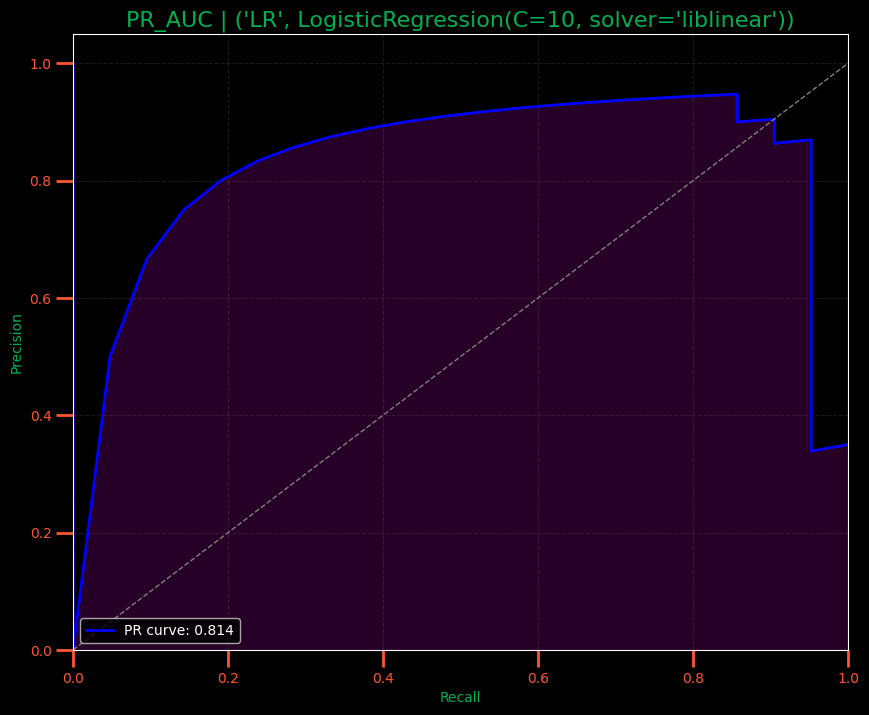

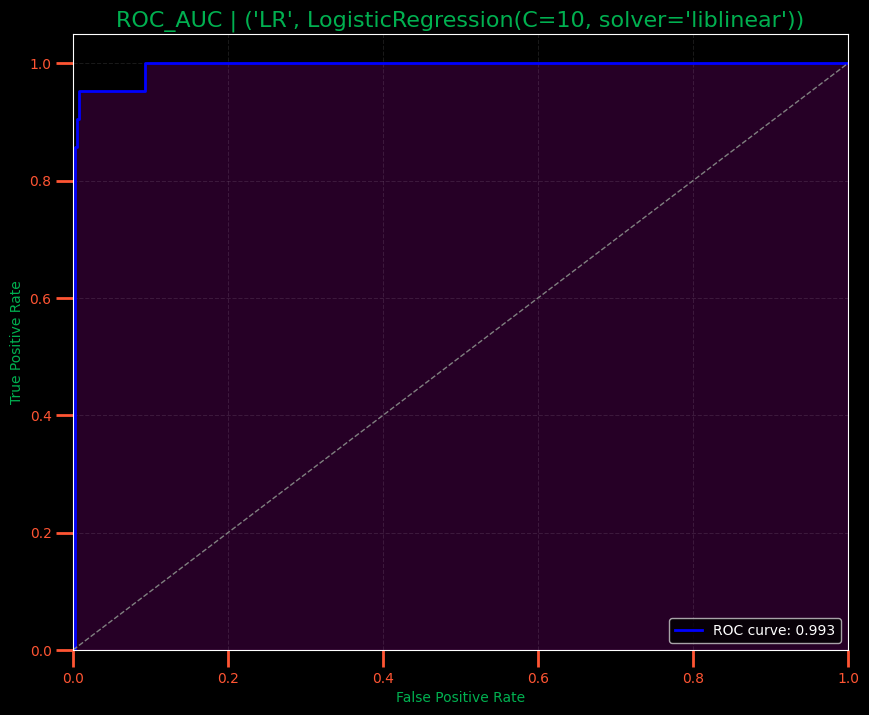

In [63]:
plot_pr_curve(best_pipe_LR, X_test, y_test, title=f'PR_AUC | {best_pipe_LR.steps[1]}')
plot_roc_curve(best_pipe_LR, X_test, y_test, title=f'ROC_AUC | {best_pipe_LR.steps[1]}')

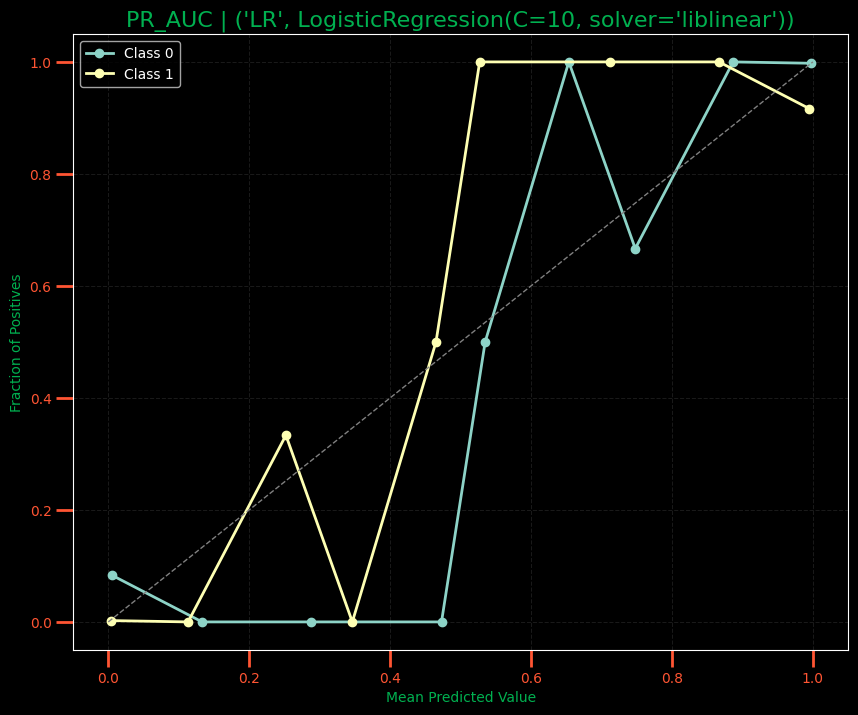

In [66]:
plot_calibration_curve(best_pipe_LR, X_test, y_test, title=f'PR_AUC | {best_pipe_LR.steps[1]}')

In [67]:
from sklearn.calibration import CalibratedClassifierCV

class PlattScalingCalibrator:
    def __init__(self, base_model):
        self.base_model = base_model
        self.calibrated_model = None

    def fit(self, X_train, y_train, method='sigmoid'):
        self.calibrated_model = CalibratedClassifierCV(self.base_model, method=method, cv='prefit')
        return self.calibrated_model.fit(X_train, y_train)

    def predict_proba(self, X):
        if not self.calibrated_model:
            raise ValueError("The model is not calibrated. Please fit the model first.")
        return self.calibrated_model.predict_proba(X)

    def predict(self, X):
        if not self.calibrated_model:
            raise ValueError("The model is not calibrated. Please fit the model first.")
        return self.calibrated_model.predict(X)

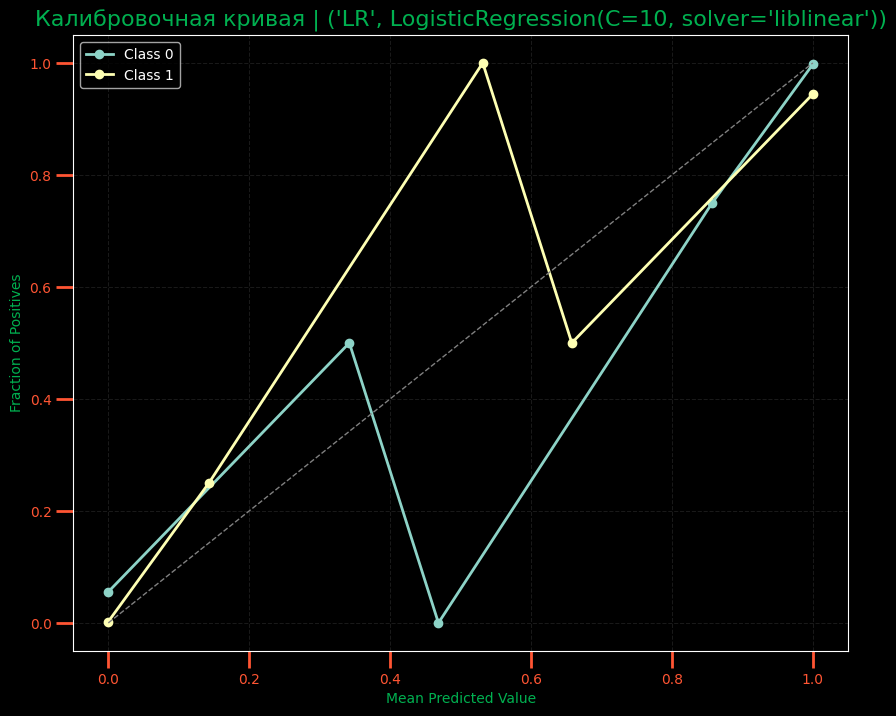

In [80]:
### Калибровка "isotonic"

calibrator = PlattScalingCalibrator(best_pipe_LR)
best_pipe_LR_calibrated_isotonic = calibrator.fit(X_train, y_train, method='isotonic')
plot_calibration_curve(best_pipe_LR_calibrated_isotonic, X_test, y_test, n_bins=10, title=f'Калибровочная кривая | {best_pipe_LR.steps[1]}')

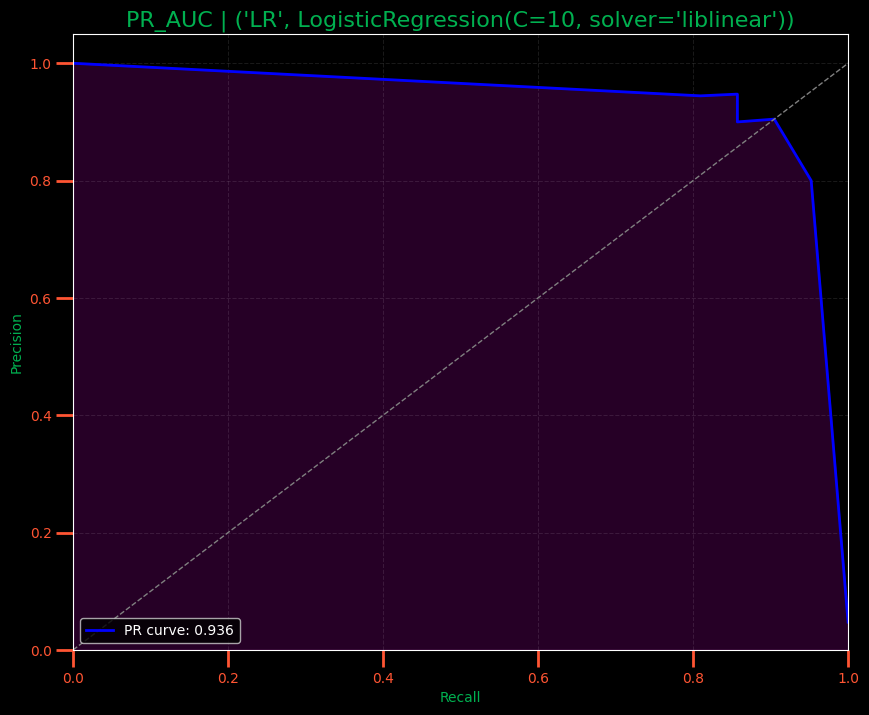

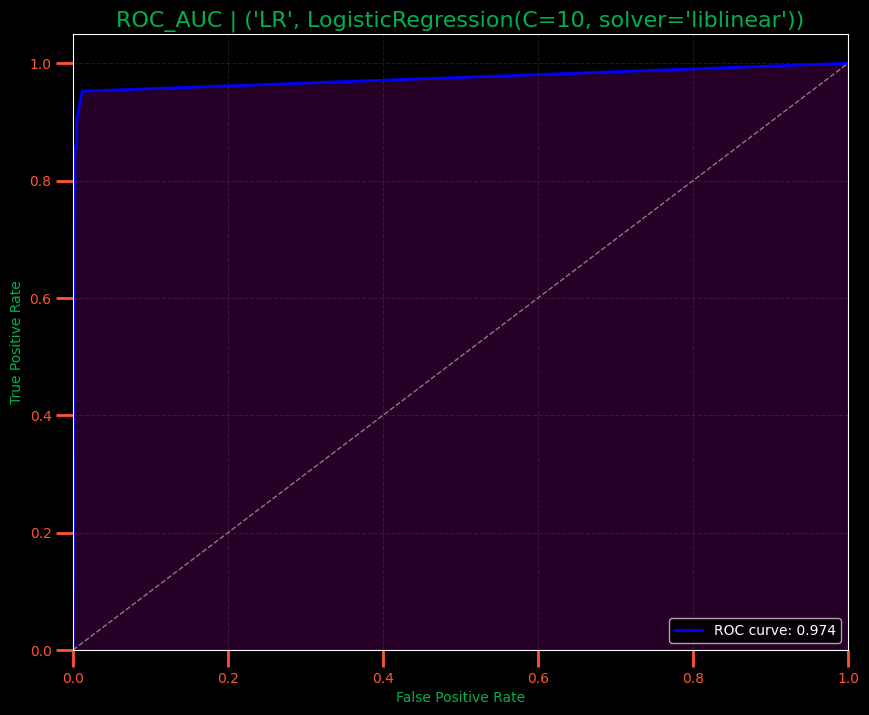

In [102]:
plot_pr_curve(best_pipe_LR_calibrated_isotonic, X_test, y_test, title=f'PR_AUC | {best_pipe_LR_calibrated_isotonic.base_estimator.steps[1]}')
plot_roc_curve(best_pipe_LR_calibrated_isotonic, X_test, y_test, title=f'ROC_AUC | {best_pipe_LR_calibrated_isotonic.base_estimator.steps[1]}')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, best_pipe_LR.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.993     0.998     0.995       423
           1      0.947     0.857     0.900        21

    accuracy                          0.991       444
   macro avg      0.970     0.927     0.948       444
weighted avg      0.991     0.991     0.991       444



In [ ]:
print(classification_report(y_test, best_pipe_LR_calibrated_isotonic.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.995     0.995     0.995       423
           1      0.905     0.905     0.905        21

    accuracy                          0.991       444
   macro avg      0.950     0.950     0.950       444
weighted avg      0.991     0.991     0.991       444



In [105]:
### Сохранение полученной модели 

import joblib

joblib.dump(best_pipe_LR_calibrated_isotonic, 'LR_calibrated_isotonic.pkl')

loaded_model = joblib.load('LR_calibrated_isotonic.pkl')
loaded_model.predict(X_test.iloc[[5]])

array([0], dtype=int64)

### Метод опорных векторов

In [107]:
from sklearn.linear_model import SGDClassifier

# Определение пайплайна

pipe_SVM = Pipeline([
    ('scaler', StandardScaler()),
    ('SVM', SGDClassifier(loss='hinge'))
])

# Подбор лучшей модели с помощью GridSearchCV

# Определение функции для вычисления PR AUC
def pr_auc_score(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    return pr_auc

# Создание объекта для применения метрики PR AUC в GridSearchCV
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=False)

param_grid = {
    'SVM__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'SVM__alpha': [0.0001, 0.001, 0.01, 0.1],
    'SVM__penalty': ['l2', 'l1', 'elasticnet'],
    'SVM__max_iter': [1000, 2000, 3000],
}

grid_search = GridSearchCV(pipe_SVM,
                           param_grid, 
                           cv = 5, 
                           scoring=pr_auc_scorer)

# Подгонка модели на обучающих данных
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'SVM__alpha': 0.0001, 'SVM__loss': 'log', 'SVM__max_iter': 2000, 'SVM__penalty': 'l1'}
Лучшая оценка: 0.8497393054776428


In [108]:
# Назначаем лучшую модель
best_pipe_SVM = grid_search.best_estimator_

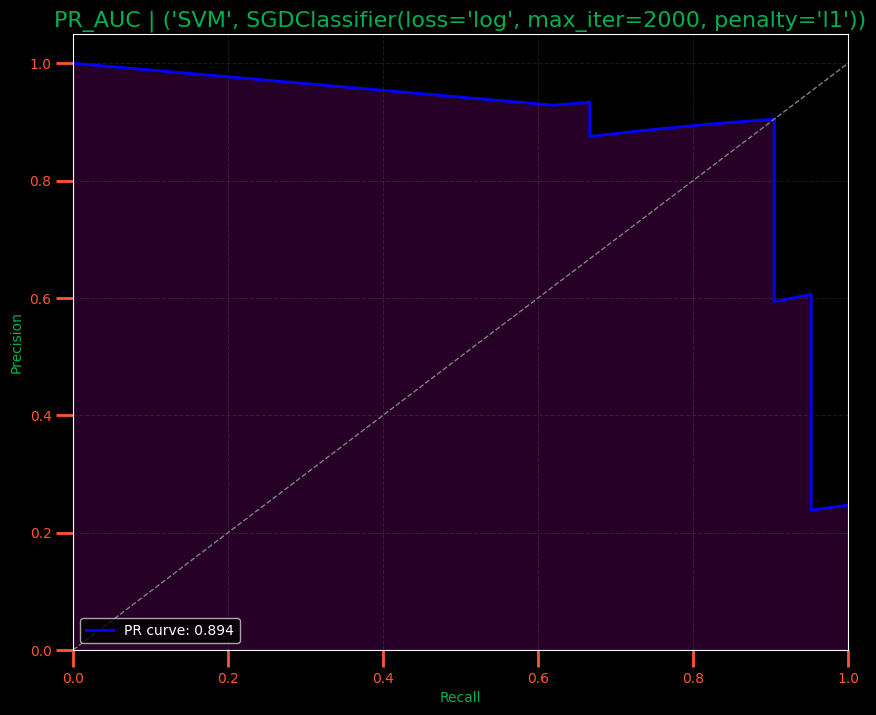

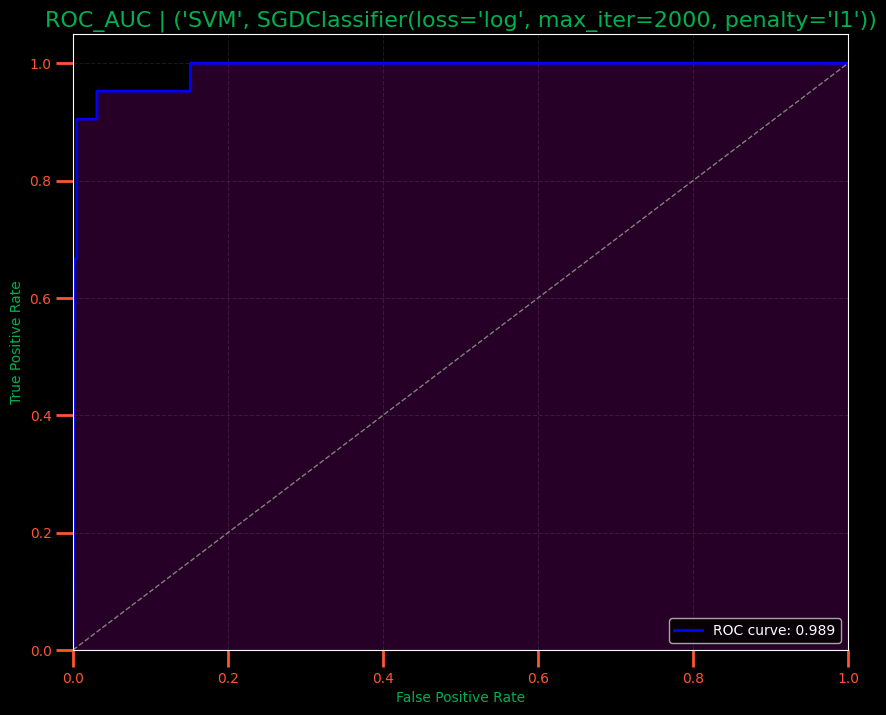

In [112]:
plot_pr_curve(best_pipe_SVM, X_test, y_test, title=f'PR_AUC | {best_pipe_SVM.steps[1]}')
plot_roc_curve(best_pipe_SVM, X_test, y_test, title=f'ROC_AUC | {best_pipe_SVM.steps[1]}')

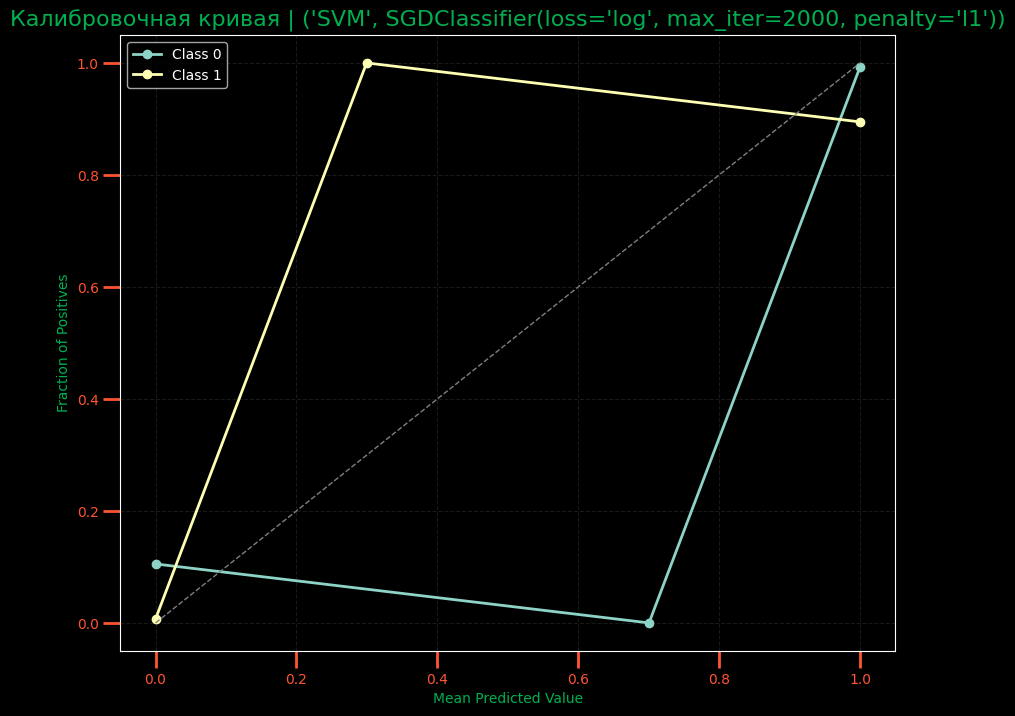

In [119]:
plot_calibration_curve(best_pipe_SVM, X_test, y_test, title=f'Калибровочная кривая | {best_pipe_SVM.steps[1]}')

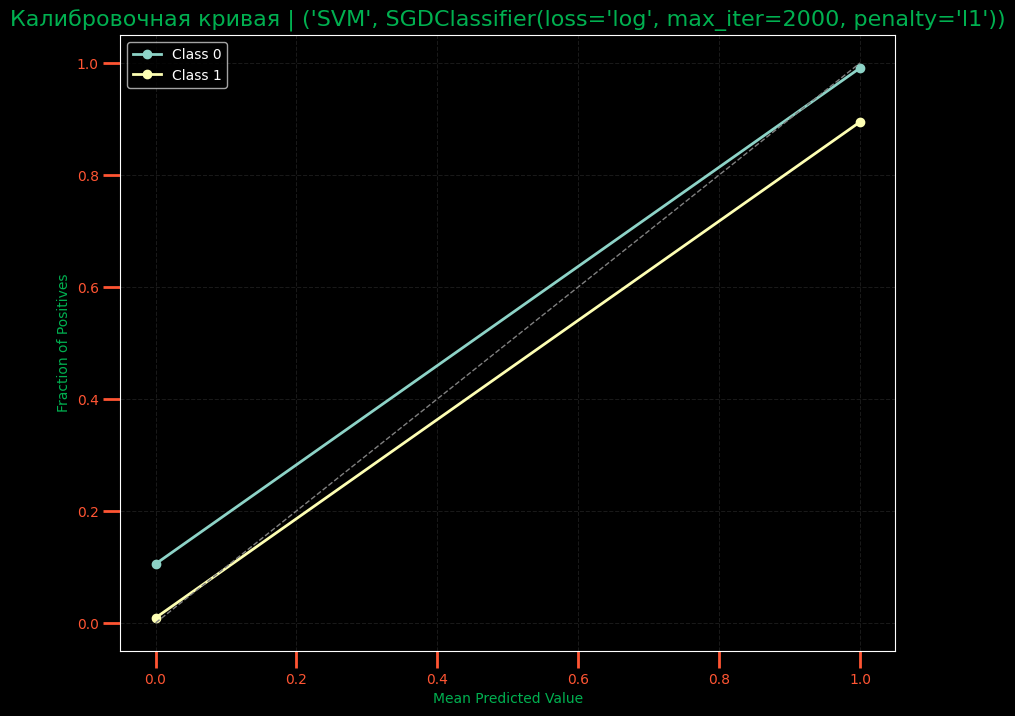

In [131]:
### Калибровка "isotonic"

calibrator = PlattScalingCalibrator(best_pipe_SVM)
best_pipe_SVM_calibrated_isotonic = calibrator.fit(X_train, y_train, method='isotonic')
plot_calibration_curve(best_pipe_SVM_calibrated_isotonic, X_test, y_test, n_bins=10, title=f'Калибровочная кривая | {best_pipe_SVM.steps[1]}')

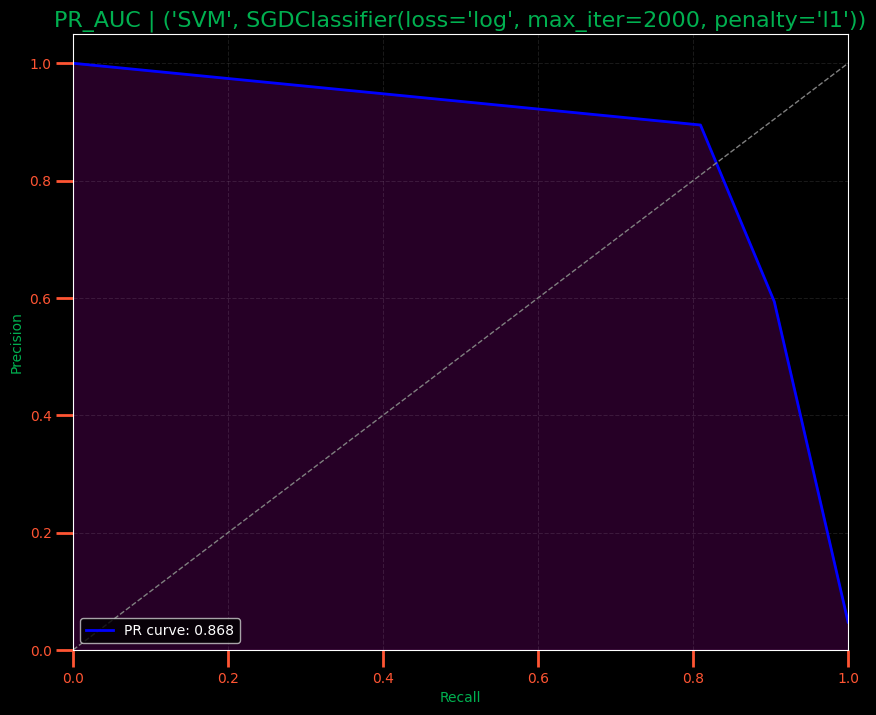

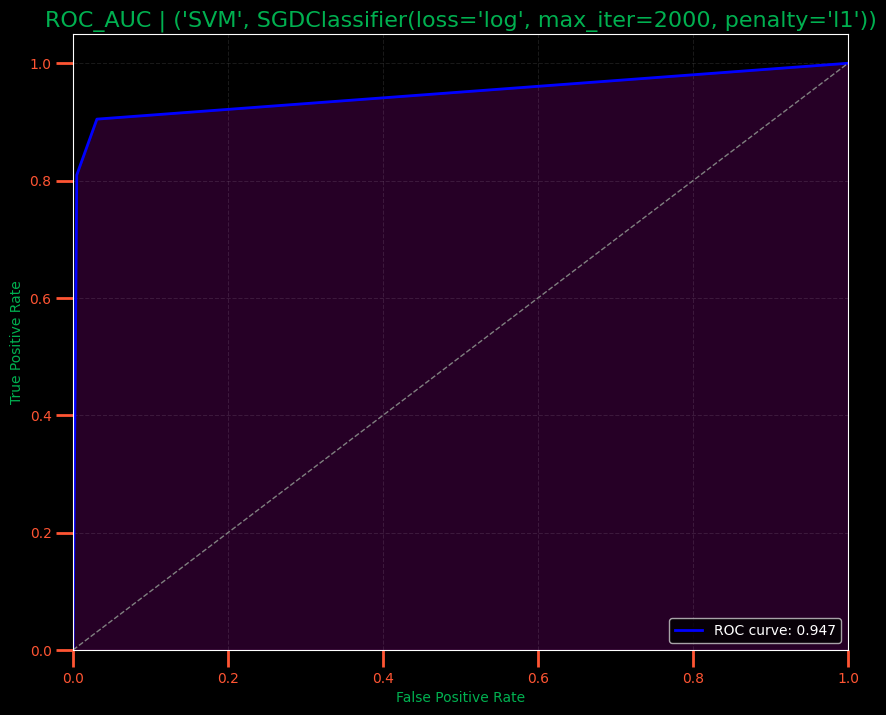

In [126]:
plot_pr_curve(best_pipe_SVM_calibrated_isotonic, X_test, y_test, title=f'PR_AUC | {best_pipe_SVM_calibrated_isotonic.base_estimator.steps[1]}')
plot_roc_curve(best_pipe_SVM_calibrated_isotonic, X_test, y_test, title=f'ROC_AUC | {best_pipe_SVM_calibrated_isotonic.base_estimator.steps[1]}')

In [121]:
print(classification_report(y_test, best_pipe_SVM.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.991     0.995     0.993       423
           1      0.895     0.810     0.850        21

    accuracy                          0.986       444
   macro avg      0.943     0.902     0.921       444
weighted avg      0.986     0.986     0.986       444



In [122]:
print(classification_report(y_test, best_pipe_SVM_calibrated_isotonic.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.991     0.995     0.993       423
           1      0.895     0.810     0.850        21

    accuracy                          0.986       444
   macro avg      0.943     0.902     0.921       444
weighted avg      0.986     0.986     0.986       444



In [127]:
### Сохранение полученной модели 

import joblib

joblib.dump(best_pipe_SVM_calibrated_isotonic, 'SVM_calibrated_isotonic.pkl')

loaded_model = joblib.load('SVM_calibrated_isotonic.pkl')
loaded_model.predict(X_test.iloc[[5]])

array([0], dtype=int64)